Import packages

In [1]:
# import the necessary packages
from matplotlib import pyplot as plt
from tensorflow.keras.applications import ResNet50 # classification model trained on imagenet dataset 1k common objects
from tensorflow.keras.applications.resnet50 import preprocess_input # preprocess before passing to resnet
from tensorflow.keras.applications import imagenet_utils # human readable names out of resent
from tensorflow.keras.preprocessing.image import img_to_array # preprocessing functions
from imutils.object_detection import non_max_suppression # combine weak boudning boxes
import numpy as np
import argparse
import cv2

Display function

In [2]:
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

Selective search function

In [3]:
# method switch enables fast or quality
def selective_search(image, method="fast"):
	# initialize OpenCV's selective search implementation and set the
	# input image. requires opencv-contrib-python and opencv-python.
	ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
	# set input image
	ss.setBaseImage(image)

	# check to see if we are using the *fast* but *less accurate* version
	# of selective search
	if method == "fast":
		ss.switchToSelectiveSearchFast()

	# otherwise we are using the *slower* but *more accurate* version
	else:
		ss.switchToSelectiveSearchQuality()

	# call process function of select search run selective search on the input image
	rects = ss.process()

	# return the region proposal bounding boxes
	return rects

Argument parser

In [4]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"image": "images/input/lifeboat2.jpg",
	"method": "fast", # this could be fast or quality
	"conf": 0.5, # if less than 90%, throw out, else it's worth computation
	"filter": "lifeboat" # remove false positive detection, we don't care about objects we arent looking for
	# list of known objects https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
}

In [5]:
# grab the label filters command line argument
labelFilters = args["filter"]

# if the label filter is not empty, break it into a list, assuming more than 1
if labelFilters is not None:
	labelFilters = labelFilters.lower().split(",")

In [6]:
# load ResNet from disk (with weights pre-trained on ImageNet)
print("[INFO] loading ResNet...")
model = ResNet50(weights="imagenet")

# load the input image from disk and grab its dimensions
image = cv2.imread(args["image"])
(H, W) = image.shape[:2]

# in other exercises we would apply image pyramid and sliding window, exhaustively

[INFO] loading ResNet...


In [7]:
# run selective search on the input image
print("[INFO] performing selective search with '{}' method...".format(
	args["method"]))
rects = selective_search(image, method=args["method"])
# the number of regions ss has found
print("[INFO] {} regions found by selective search".format(len(rects)))

# initialize the list of region proposals that we'll be classifying
# along with their associated bounding boxes
proposals = []
boxes = [] # for each proposal. this is the coordinates from the ROI

[INFO] performing selective search with 'fast' method...
[INFO] 16580 regions found by selective search


In [8]:
# loop over the region proposal bounding box coordinates generated by
# running selective search
for (x, y, w, h) in rects:
	# if the width or height of the region is less than 10% of the
	# image width or height, ignore it (i.e., filter out small
	# objects that are likely false-positives)
	# if small objects, and region is massive, may flip
	# remove entirely
	if w / float(W) < 0.1 or h / float(H) < 0.1:
		continue

	# numpy array slicing
	# extract the region from the input image, convert it from BGR to
	# RGB channel ordering, and then resize it to 224x224 (the input
	# dimensions required by our pre-trained CNN)
	roi = image[y:y + h, x:x + w]
	roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
	roi = cv2.resize(roi, (224, 224)) # input image dimensions for resnet

	# further preprocess by the ROI
	roi = img_to_array(roi) # convert to array with TF Keras channel ordering
	roi = preprocess_input(roi) # resent preprocessing mean subtracting and scaling

	# update our proposals and bounding boxes lists
	proposals.append(roi)
	boxes.append((x, y, w, h)) # update with bounding box coordinates

In [9]:
# convert the proposals list into NumPy array and show its dimensions
proposals = np.array(proposals)
print("[INFO] proposal shape: {}".format(proposals.shape))

# classify each of the proposal ROIs using ResNet and then decode the
# predictions
print("[INFO] classifying proposals...")
# pass in predictions
preds = model.predict(proposals)
# decode the human readable label
preds = imagenet_utils.decode_predictions(preds, top=1)

# initialize a dictionary which maps class labels (keys) to any
# bounding box associated with that label (values) = 2tuple
labels = {}

[INFO] proposal shape: (690, 224, 224, 3)
[INFO] classifying proposals...


In [10]:
# loop over the predictions
for (i, p) in enumerate(preds):
	# grab the prediction information for the current region proposal
	(imagenetID, label, prob) = p[0]

	# only if the label filters are not empty *and* the label does not
	# exist in the list, then ignore it dont waste compute on objects that dont matter
	if labelFilters is not None and label not in labelFilters:
		continue

	# filter out weak detections by ensuring the predicted probability
	# is greater than the minimum probability
	if prob >= args["conf"]:
		# grab the bounding box associated with the prediction and
		# convert the coordinates
		(x, y, w, h) = boxes[i]
		box = (x, y, x + w, y + h)

		# grab the list of predictions for the label and add the
		# bounding box + probability to the list
		L = labels.get(label, [])
		L.append((box, prob))
		labels[label] = L

[INFO] showing results for 'lifeboat'


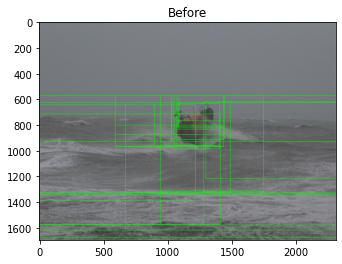

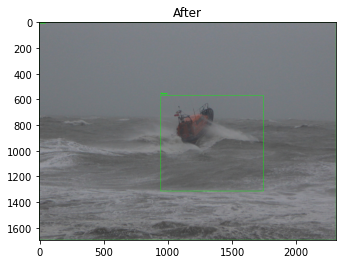

In [11]:
# loop over the labels for each of detected objects in the image
for label in labels.keys():
	# clone the original image so that we can draw on it
	print("[INFO] showing results for '{}'".format(label))
	clone = image.copy()

	# loop over all bounding boxes for the current label
	for (box, prob) in labels[label]:
		# draw the bounding box on the image
		(startX, startY, endX, endY) = box
		cv2.rectangle(clone, (startX, startY), (endX, endY),
			(0, 255, 0), 2)

	# show the results *before* applying non-maxima suppression, then
	# clone the image again so we can display the results *after*
	# applying non-maxima suppression
	plt_imshow("Before", clone)
	clone = image.copy()

    # extract the bounding boxes and associated prediction
	# probabilities, then apply non-maxima suppression
	boxes = np.array([p[0] for p in labels[label]])
	proba = np.array([p[1] for p in labels[label]])
	boxes = non_max_suppression(boxes, proba)

	# loop over all bounding boxes that were kept after applying
	# non-maxima suppression
	for (startX, startY, endX, endY) in boxes:
		# draw the bounding box and label on the image
		cv2.rectangle(clone, (startX, startY), (endX, endY),
			(0, 255, 0), 2)
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.putText(clone, label, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

	# show the output after apply non-maxima suppression
	plt_imshow("After", clone)